# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [32]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [11]:
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
import time

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Overview of available datasets
* **Part 2**: Cleaning the data
* **Part 3**: Brief check for remaining data leakage

<div class='exercise'><b> Part 1: Overview of available datasets </b></div>

The Lending Club raw data as downloaded from: https://www.lendingclub.com/info/download-data.action. 

Two sets of data are available: 
- **Loan data**: data for all loans issued through the time period stated. 
- **Declined loan data**: details of all loan applications that did not meet Lending Club's credit underwriting policy.

For this project, we use only the Loan data.  This is split into several datasets covering different time periods. The file names and the years they cover are as follows:

- LoanStats_3a: covers the years 2007 - 2011
- LoanStats_3b: 2012 - 2013
- LoanStats_3c: 2014
- LoanStats_3d: 2015
- After this point, loan data is issued by quarter and the naming format is LoanStats_YYYYQQ, e.g. LoanStats_2016Q1 refers to Q1 of 2016

We have elected to focus on the data for 2016 and 2017 for the purposes of training the model. This is because:
* The variables included in the datasets have changed over time, meaning that features in the more recent datasets are not necessarily available in the older datasets. 
* We will focus on loans that have completed their full life cycle (i.e. loan status of fully paid or charged off), since the status of current loans may change over time. 
* Since the model will be used to inform an investment strategy going forwards, the most relevant data are from recent years.


In [12]:
# increase some display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

In [42]:
# Read in the data sets from local files
Q1_2017 = pd.read_csv('../../../data/raw/LoanStats_2017Q1.csv',low_memory=False,skiprows=1)
Q2_2017 = pd.read_csv('../../../data/raw/LoanStats_2017Q2.csv',low_memory=False,skiprows=1)
Q3_2017 = pd.read_csv('../../../data/raw/LoanStats_2017Q3.csv',low_memory=False,skiprows=1)
Q4_2017 = pd.read_csv('../../../data/raw/LoanStats_2017Q4.csv',low_memory=False,skiprows=1)

Q1_2016 = pd.read_csv('../../../data/raw/LoanStats_2016Q1.csv',low_memory=False,skiprows=1)
Q2_2016 = pd.read_csv('../../../data/raw/LoanStats_2016Q2.csv',low_memory=False,skiprows=1)
Q3_2016 = pd.read_csv('../../../data/raw/LoanStats_2016Q3.csv',low_memory=False,skiprows=1)
Q4_2016 = pd.read_csv('../../../data/raw/LoanStats_2016Q4.csv',low_memory=False,skiprows=1)

In [43]:
# Concatenate just 2016/2017
Year_2016_2017 = pd.concat([Q1_2017,Q2_2017,Q3_2017,Q4_2017,Q1_2016,Q2_2016,Q3_2016,Q4_2016])


In [44]:
Year_2016_2017.shape

(878002, 151)

<div class='exercise'><b> Part 2: Cleaning the data </b></div>

Below is a summary of all of the cleaning functions.

### Columns removed

Columns were removed for two reasons:
* Uninformative columns, e.g. those that contained no data
* Data leakage, i.e. those that contained information that would only become available after the loan has been issued.  We contacted Lending Club who indicated which columns were updated monthly and which were available at the time of application. 

The following columns were removed because they contained no information: 
* `member_id`, `url`, `desc` have no data
* `policy_code` has only one value
* `title` repeats the information in `purpose`
* `emp_title` would require too much cleaning to create useful features

The following columns were removed because of data leakage:
* All columns that refer to the current status of the loan: 
    * `recoveries`, `collection_recovery_fee`, `out_prncp`, `out_prncp_inv`
    * `total_pymnt`, `total_pymnt_inv` etc.
    * All columns starting with `last_....` and `next...`
* All columns related to `debt settlement` 
* All columns related to `hardship flags`

the following columns were removed because they're referring to a second application:
* All columns starting with `sec_` or ending in `_joint`, which refer to joint applications. 
    * The exception is `sec_app_mths_since_last_major_derog`, which refers to the months since most recent 90-day or worse rating at time of application for the secondary applicant. Filling missing values with 0 would suggest that there had been a recent occurrence, when in fact the missing values mean that there has never been an occurrence.  This column is turned into a binary column with 0 meaning no occurrence and 1 meaning there has been an occurrence. 
    
### Fill missing values

For the following columns, missing values were filled with zeros:
* Fill missing values with data from joint application column:
    * `mort_acc` filled from `sec_app_mort_acc` or 0 if that column is also NaN
* All of the `mths_since...` variables have many missing values. We cannot replace NaNs with 0's since this would suggest that there had been a recent occurrence.  Therefore these are recoded as binary variables with 0 indicating no occurrence and 1 indicating an occurrence. 
* For the remaining columns, it makes sense to fill NaNs with 0's, since these typically refer to "number of X occurrence".

### Recoding data

* Convert to dates: `issue_d`, `earliest_cr_line` and keep only the year
* Convert to numeric: `emp_length`
* Convert to numeric: `int_rate`, `revol_util`
* `term`: 0 = 36 months, 1 = 60 months
* `initial_list_status`: 0 = fractional loan, 1 = whole loan
* `application_type`: 0 = individual, 1 = joint
* `hardship_flag`: 0 = No, 1 = Yes
* `mths since...`: 0 = No occurrence 1 = Occurrence
* `pymt_plan`: 0 = No, 1 = Yes

### Target variable

* The target variable is `loan_status`. As discussed earlier, we drop all rows where loan status is not equal to fully paid or charged off, since these loans have completed their full lifecycle.


In [45]:
# New function
def clean_up(df):
    
    # Explicitly list the columns by cleaning action
    cols_to_drop = set(['member_id', 'url', 'desc', 
                    "hardship_flag", "hardship_type","hardship_reason","hardship_status","deferral_term",
                        "hardship_amount","hardship_start_date","hardship_end_date","payment_plan_start_date",
                        "hardship_length","hardship_dpd","hardship_loan_status",
                        "orig_projected_additional_accrued_interest","hardship_payoff_balance_amount",
                        "hardship_last_payment_amount","disbursement_method","debt_settlement_flag",
                        "debt_settlement_flag_date","settlement_status","settlement_date","settlement_amount",
                        "settlement_percentage","settlement_term",'policy_code', 'emp_title',
                        'verification_status_joint', 'title', "sec_app_earliest_cr_line", "out_prncp", 
                        "out_prncp_inv", "recoveries", "sec_app_fico_range_low", "sec_app_fico_range_high",
                        "last_credit_pull_d", "last_pymnt_amnt", "last_pymnt_d", "next_pymnt_d",
                        "total_pymnt", "total_pymnt_inv", "total_rec_int", "total_rec_late_fee", "total_rec_prncp", 
                        "tot_coll_amt", 'tot_cur_bal', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
                        'total_bc_limit', 'total_il_high_credit_limit',
                        "collection_recovery_fee", "collections_12_mths_ex_med", 
                        "sec_app_collections_12_mths_ex_med", "sec_app_chargeoff_within_12_mths", 
                        "sec_app_num_rev_accts", "sec_app_open_act_il", "sec_app_open_acc", 
                        "sec_app_inq_last_6mths",'last_fico_range_high', 'last_fico_range_low'
                   ])
    date_cols_to_keep = ['issue_d', 'earliest_cr_line']
    fill_zero_cols = set(["revol_bal_joint", "annual_inc_joint", "dti_joint", 
                          'inq_last_6mths', 'inq_last_12m', 'open_acc_6m', 'open_act_il', 
                          'open_il_12m', 'open_il_24m', 'open_rv_12m','open_rv_24m', 'inq_fi', 'pct_tl_nvr_dlq',
                          'num_accts_ever_120_pd', 'num_actv_bc_tl','num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
                          'num_il_tl', 'num_op_rev_tl', 'num_rev_accts','num_rev_tl_bal_gt_0','num_sats',
                          'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m', 'acc_open_past_24mths',
                          "num_tl_120dpd_2m", "pct_tl_nvr_dlq", "percent_bc_gt_75", 'total_bal_il',
                          'il_util', 'max_bal_bc', 'all_util', 'total_cu_tl', 'bc_open_to_buy','bc_util',
                          'avg_cur_bal', "sec_app_revol_util", "sec_app_mort_acc"
 ])
    mths_since_cols = ["mths_since_last_record", "mths_since_recent_bc_dlq", "mths_since_last_major_derog", 
                       "mths_since_recent_revol_delinq", "mths_since_last_delinq", "mths_since_recent_inq", 
                       "mo_sin_old_il_acct", "mths_since_rcnt_il", "mths_since_recent_bc", 
                       "sec_app_mths_since_last_major_derog","mo_sin_old_rev_tl_op", "mo_sin_old_il_acct", 
                       "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl"]


    # Dictionary for recoding employment length
    emp_dict = {"< 1 year":0.5, # Choose 0.5 instead of 0 to distinguish from NaN
                "1 year":1,
                "2 years":2,
                "3 years":3,
                "4 years":4,
                "5 years":5,
                "6 years":6,
                "7 years":7,
                "8 years":8,
                "9 years":9,
                "10+ years":10,
                "n/a":0}
    
    # Remove columns to drop
    df.drop(columns = cols_to_drop, inplace = True)

    # Drop rows which are not equal to 'Fully Paid' or 'Charged Off'
    df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    
    # Convert date columns to datetime 
    for i in date_cols_to_keep:
        df[i] = pd.to_datetime(df[i])
    df["issue_d"] = df["issue_d"].dt.year
    df["earliest_cr_line"] = df["earliest_cr_line"].dt.year

    # Fill missing values for selected columns
    for i in fill_zero_cols:
        df[i] = df[i].replace(np.nan, 0)
    df["revol_util"].fillna(df["sec_app_revol_util"], inplace = True)
    df["dti"].fillna(df["dti_joint"], inplace = True)
    df["mort_acc"].fillna(df["sec_app_mort_acc"], inplace = True)

    # Recode binary variables
    df["term"].replace({" 36 months": 0, " 60 months": 1}, inplace = True)
    df["pymnt_plan"].replace({"n": 0, "y": 1}, inplace = True)
    df["initial_list_status"].replace({"f": 0, "w": 1}, inplace = True)
    df["application_type"].replace({"Individual": 0, "Joint App": 1}, inplace = True)
    for i in mths_since_cols:
        df[i] = df[i].apply(lambda x: 1 if not pd.isnull(x) else 0)

    # Change emp_length to numeric
    df["emp_length"].replace(emp_dict, inplace = True)
    df["emp_length"] = df["emp_length"].replace(np.nan, 0)    

    # Strip out % signs and change to floats
    df["int_rate"] = [x.strip("%") for x in df["int_rate"].astype(str)]
    df["int_rate"] = df["int_rate"].astype(float)
    df["revol_util"] = [x.strip("%") for x in df["revol_util"].astype(str)]
    df["revol_util"] = df["revol_util"].astype(float)
    
    return df

In [46]:
# show all predictors that still have at least one NaN
def show_NaN(df):
    check_isna = df.isna().sum()
    for i in zip(check_isna.index, check_isna.values):
        if i[1] != 0:
            print(i)

In [47]:
df = clean_up(Year_2016_2017)

In [48]:
# No missing values
print(df.isnull().any().sum())
show_NaN(df)

0


In [49]:
display(df.shape)
df.head()

(334109, 89)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,revol_bal_joint,sec_app_mort_acc,sec_app_revol_util,sec_app_mths_since_last_major_derog
15,102675947,14000.0,14000.0,14000.0,1,15.99,340.38,C,C5,10.0,RENT,43000.0,Source Verified,2017,Charged Off,0,debt_consolidation,367xx,AL,21.80,1.0,1995,670.0,674.0,0.0,1,0,3.0,0.0,18537.0,99.1,8.0,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,8035.0,42.0,0.0,0.0,18537.0,70.0,0.0,0.0,0.0,0.0,8857.0,163.0,99.1,0.0,0.0,1,1,1,1,0.0,1,0,0,0,0.0,1.0,1.0,1.0,2.0,5.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,87.5,100.0,0.0,0.0,0.0,0.0,0.0,0
20,104220223,5000.0,5000.0,5000.0,0,14.99,173.31,C,C4,10.0,RENT,68000.0,Not Verified,2017,Fully Paid,0,debt_consolidation,945xx,CA,22.50,0.0,2003,660.0,664.0,0.0,1,0,6.0,0.0,10276.0,90.1,18.0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1,25892.0,64.0,0.0,0.0,4261.0,69.0,1.0,1.0,0.0,2.0,6028.0,1124.0,90.1,0.0,0.0,1,1,1,1,0.0,1,0,1,0,0.0,4.0,4.0,4.0,6.0,8.0,4.0,9.0,4.0,6.0,0.0,0.0,0.0,0.0,94.4,75.0,0.0,0.0,0.0,0.0,0.0,0
21,104090118,10150.0,10150.0,10150.0,0,7.24,314.52,A,A3,8.0,MORTGAGE,50000.0,Not Verified,2017,Fully Paid,0,debt_consolidation,773xx,TX,29.60,0.0,2002,740.0,744.0,1.0,0,0,9.0,0.0,21845.0,56.0,21.0,1,0,0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1,23502.0,43.0,0.0,0.0,11270.0,49.0,1.0,1.0,2.0,2.0,29908.0,13951.0,58.2,0.0,0.0,1,1,1,1,3.0,1,0,1,0,0.0,3.0,4.0,3.0,5.0,8.0,5.0,10.0,4.0,9.0,0.0,0.0,0.0,2.0,100.0,33.3,0.0,0.0,0.0,0.0,0.0,0
22,103739310,8400.0,8400.0,8400.0,0,11.39,276.56,B,B3,8.0,MORTGAGE,50000.0,Source Verified,2017,Charged Off,0,other,454xx,OH,15.63,0.0,2005,675.0,679.0,0.0,0,0,14.0,0.0,12831.0,30.3,30.0,1,0,0,0.0,0.0,0.0,3.0,2.0,1.0,2.0,1,38760.0,105.0,4.0,8.0,5338.0,65.0,4.0,1.0,7.0,10.0,12389.0,24145.0,33.1,0.0,0.0,1,1,1,1,4.0,1,0,1,0,0.0,4.0,5.0,7.0,11.0,9.0,11.0,16.0,5.0,14.0,0.0,0.0,0.0,5.0,100.0,14.3,0.0,0.0,0.0,0.0,0.0,0
26,104046532,10000.0,10000.0,10000.0,0,12.74,335.69,C,C1,10.0,OWN,40000.0,Not Verified,2017,Fully Paid,0,debt_consolidation,324xx,FL,8.85,0.0,1997,700.0,704.0,0.0,0,0,7.0,0.0,9227.0,55.9,15.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,3.0,5454.0,56.0,0.0,0.0,1.0,3.0,1318.0,1691.0,79.4,0.0,0.0,1,1,1,1,2.0,1,0,1,0,0.0,2.0,4.0,2.0,3.0,2.0,7.0,11.0,4.0,7.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,0.0,0.0,0.0,0.0,0


In [50]:
# Save
df.to_csv("../../../data/data_cleaned_2016_2017_id.csv", index = False)

<div class='exercise'><b> Part 3: Brief check for remaining data leakage </b></div>

Data leakage is difficult to detect automatically, but since it can lead to artificially high accuracy of a model, we do a quick check to see if the basic model using all predictors performs suspiciously well, and to see what predictors are contributing most to this. 

In [22]:
# Check balance of target values - rather imbalanced
df["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,255116
Charged Off,78993


In [23]:
# Downsample and create balanced classes
from sklearn.utils import resample

df_majority = df[df["loan_status"] == "Fully Paid"]
df_minority = df[df["loan_status"] == "Charged Off"]

n_samples = 10000

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace = False,    # sample without replacement
                                 n_samples = n_samples,   
                                 random_state = 1) 

# Downsample minority class
df_minority_downsampled = resample(df_minority, 
                                 replace = False,    # sample without replacement
                                 n_samples = n_samples,   
                                 random_state = 1) 

# Recombine
df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

df_downsampled["loan_status"].value_counts().to_frame()


,loan_status
Fully Paid,10000
Charged Off,10000


In [24]:
# Train test split
data_train, data_test = train_test_split(df_downsampled, test_size = 0.2)

In [25]:
# Split into train and test sets
X_train = data_train.iloc[:, data_train.columns != 'loan_status']
y_train = data_train['loan_status'].values
X_test = data_test.iloc[:, data_test.columns != 'loan_status']
y_test = data_test['loan_status'].values

In [26]:
# Select only numerical columns - since it is only numerical columns we are unsure of regarding data leakage
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [27]:
# Fit a simple tree to check whether there is any remaining data leakage
tree = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train)

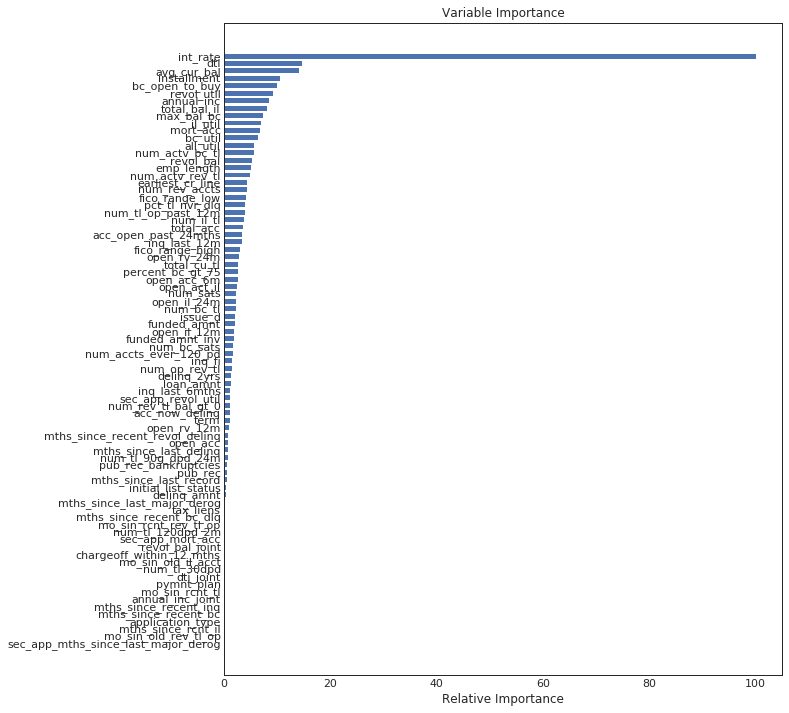

In [28]:
# Check that the top features make sense
feature_importance = tree.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [29]:
# Check accuracy is not too high - seems OK!
accuracy_score(tree.predict(X_test), y_test)

0.614

In [30]:
# Check with random forest - accuracy seems OK
rf = RandomForestClassifier(n_estimators=int(X_train.shape[1]/2), 
                            max_depth = 2).fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

0.64

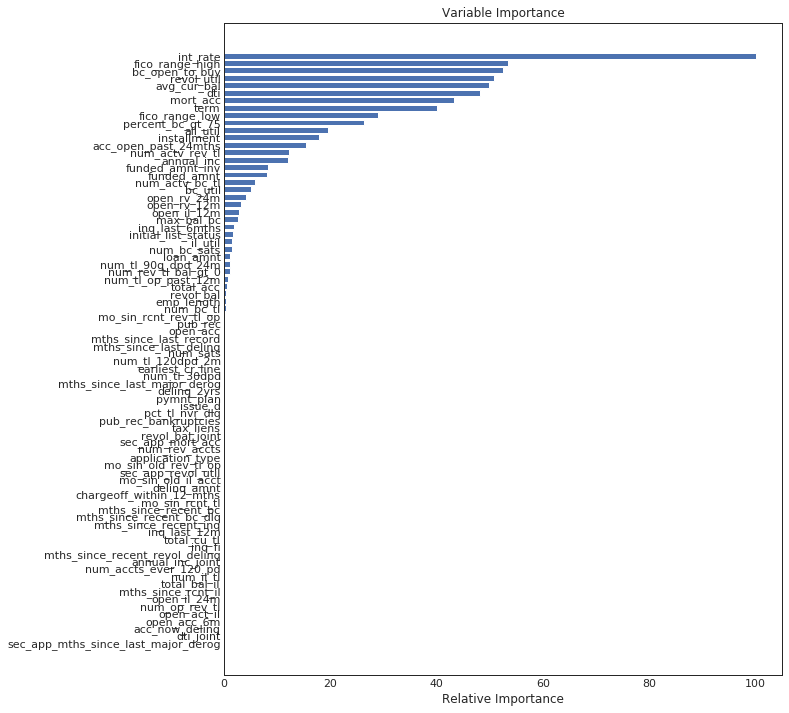

In [31]:
# Check that the top features make sense
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');